# 📝 Exercise M7.01

This notebook aims at building baseline classifiers, which we'll use to
compare our predictive model. Besides, we will check the differences with
the baselines that we saw in regression.

We will use the adult census dataset, using only the numerical features.

In [1]:
import os

os.makedirs("../../datasets", exist_ok=True)

In [2]:
%%bash

wget -qO "../../datasets/adult-census-numeric-all.csv" "https://github.com/INRIA/scikit-learn-mooc/raw/master/datasets/adult-census-numeric-all.csv"

In [3]:
import pandas as pd

adult_census = pd.read_csv("../../datasets/adult-census-numeric-all.csv")
data, target = adult_census.drop(columns="class"), adult_census["class"]
adult_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   education-num   48842 non-null  int64 
 2   capital-gain    48842 non-null  int64 
 3   capital-loss    48842 non-null  int64 
 4   hours-per-week  48842 non-null  int64 
 5   class           48842 non-null  object
dtypes: int64(5), object(1)
memory usage: 2.2+ MB


First, define a `ShuffleSplit` cross-validation strategy taking half of the
sample as a testing at each round.

In [4]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)

We can display an interactive diagram with the following command:

In [6]:
from sklearn import set_config
set_config(display='diagram')

Next, create a machine learning pipeline composed of a transformer to
standardize the data followed by a logistic regression.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

classifier = make_pipeline(StandardScaler(),
    LogisticRegression())
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Get the test score by using the model, the data, and the cross-validation
strategy that you defined above.

In [9]:
from sklearn.model_selection import cross_validate

result_classifier = cross_validate(classifier, data, target,
    cv=cv, n_jobs=2)
test_score_classifier = pd.Series(result_classifier['test_score'],
    name='Classfier score')
test_score_classifier.head()

0    0.815937
1    0.813849
2    0.815036
3    0.815569
4    0.810982
Name: Classfier score, dtype: float64

Using the `sklearn.model_selection.permutation_test_score` function,
check the chance level of the previous model.

In [10]:
from sklearn.model_selection import permutation_test_score

score, permutation_score, pvalue = permutation_test_score(
    classifier, data, target, cv=cv, n_jobs=2, n_permutations=10)
test_score_permutation = pd.Series(permutation_score, 
    name="Permuted score")
test_score_permutation.head()

0    0.760112
1    0.761238
2    0.760550
3    0.761398
4    0.761001
Name: Permuted score, dtype: float64

Finally, compute the test score of a dummy classifier which would predict
the most frequent class from the training set. You can look at the
`sklearn.dummy.DummyClassifier` class.

In [12]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
result_dummy = cross_validate(dummy, data, target,
    cv=cv, n_jobs=2)
test_score_dummy = pd.Series(result_dummy['test_score'], 
    name='Dummy score')
test_score_dummy.head()

0    0.760329
1    0.756808
2    0.759142
3    0.760739
4    0.761681
Name: Dummy score, dtype: float64

Now that we collected the results from the baselines and the model, plot
the distributions of the different test scores.

We concatenate the different test score in the same pandas dataframe.

In [13]:
final_test_scores = pd.concat([test_score_classifier, 
    test_score_permutation, test_score_dummy], axis=1)
final_test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Classfier score  10 non-null     float64
 1   Permuted score   10 non-null     float64
 2   Dummy score      10 non-null     float64
dtypes: float64(3)
memory usage: 368.0 bytes


Next, plot the distributions of the test scores.

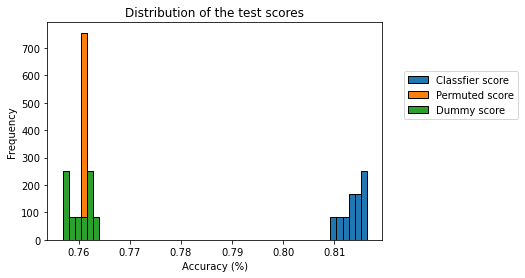

In [15]:
import matplotlib.pyplot as plt

final_test_scores.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the test scores")

We observe that the dummy classifier with the strategy `most_frequent` is equivalent to the permutation score. We can also conclude that our model is better than the other baseline.

Change the strategy of the dummy classifier to `stratified`, compute the
results and plot the distribution together with the other results. Explain
why the results get worse.

In [16]:
dummy = DummyClassifier(strategy='stratified')
result_dummy_stratify = cross_validate(dummy, data, target,
    cv=cv, n_jobs=2)
test_score_dummy_stratify = pd.Series(
    result_dummy_stratify['test_score'], 
    name="Dummy 'stratify' score")
test_score_dummy_stratify.head()

0    0.636133
1    0.639163
2    0.637607
3    0.633144
4    0.634904
Name: Dummy 'stratify' score, dtype: float64

In [17]:
final_test_scores = pd.concat([
    test_score_classifier, 
    test_score_permutation, 
    test_score_dummy, 
    test_score_dummy_stratify
    ], axis=1)
final_test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Classfier score         10 non-null     float64
 1   Permuted score          10 non-null     float64
 2   Dummy score             10 non-null     float64
 3   Dummy 'stratify' score  10 non-null     float64
dtypes: float64(4)
memory usage: 448.0 bytes


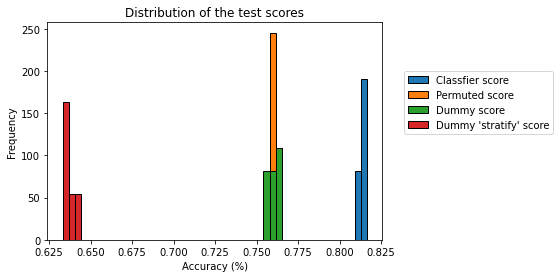

In [18]:
final_test_scores.plot.hist(bins=50, density=True, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the test scores")

We see that using `strategy="stratified"`, the results are much worse than with the `most_frequent` strategy. Since the classes are imbalanced, predicting the most frequent involves that we will be right for the proportion of this class (~75% of the samples). However, by using the `stratified` strategy, wrong predictions will be made even for the most frequent class, hence we obtain a lower accuracy.